<a href="https://colab.research.google.com/github/MikeXL/brain/blob/master/iris_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MJ LOG 0130.031118

Finnaly it meet the need for a vanilla neural net to predict the wine class based on the available features.

**Data prep**
*sklearn* does provide preprocessing and train, validation, test split

**Data exploration**
*matplot* is convenient enough for simple histogram, boxplot, trend lines, bar chart, scatter plot, 
[gallery](https://matplotlib.org/2.1.1/gallery/index.html) here to have fun

**Modeling**
*pytorch* is intuitive enough to use, with minor painful points that have to solve along the way such as 
weight reset in order to start clean, that has not been mentioned in documentation, or at least I have not seen 
rather than in forum post.Other than that it is a smooth ride.

**Validation**
Currently simply calculating the misclassification rate, not ideal. 

Next step for me, 
1. *Hyperarameter tuning* such as learning rate along with different optimization technique (L-BFGS, Adam, SGD, RMSprop etc.) 
and plot their performance against one another. Perhaps throw in different loss function too.
2. Validate model with validation dataset, along with measures like ROC, lift, gain, confusion matrix, F1, refer [here](http://scikit-learn.org/stable/modules/model_evaluation.html) from sklearn

Once that is done, then move onto attention network, autoencoder, Q network and GAN.

In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html


In [0]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

In [0]:
from sklearn import datasets
wine = datasets.load_wine()


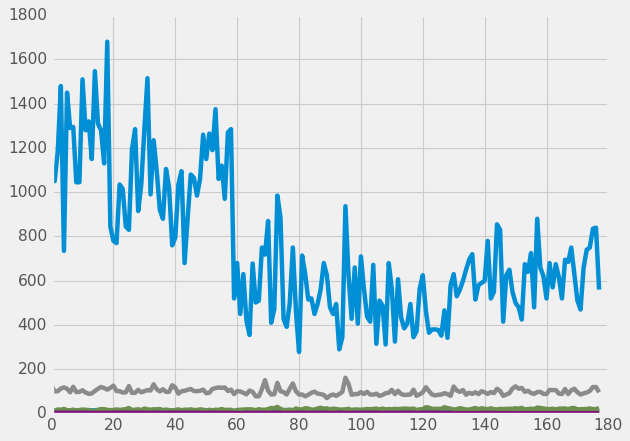

In [458]:
plt.plot(wine.data)

In [459]:
wine.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

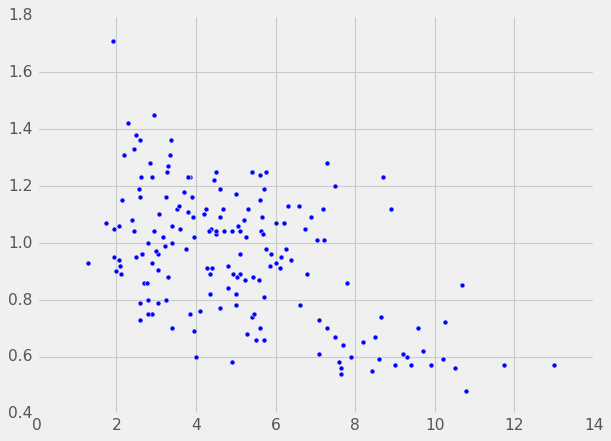

In [462]:
plt.scatter(wine.data[:, -4], wine.data[:, -3])

{'boxes': [<matplotlib.lines.Line2D at 0x7f817d6b9fd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f817d770ad0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f817d6d5a50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f817d770cd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f817d6b9dd0>,
  <matplotlib.lines.Line2D at 0x7f817d7701d0>]}

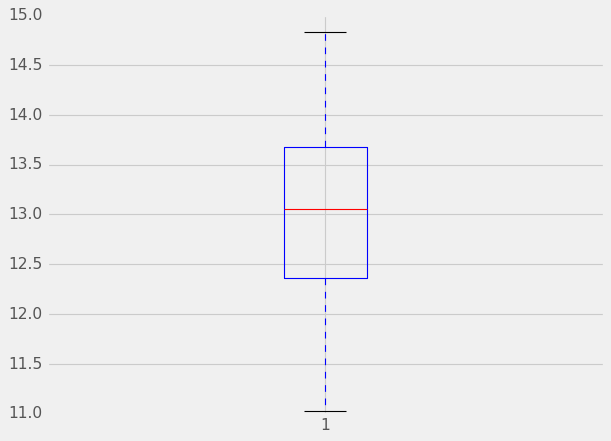

In [463]:
plt.boxplot(wine.data[:, 0])

In [460]:
print wine.DESCR

Wine Data Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- 1) Alcohol
 		- 2) Malic acid
 		- 3) Ash
		- 4) Alcalinity of ash  
 		- 5) Magnesium
		- 6) Total phenols
 		- 7) Flavanoids
 		- 8) Nonflavanoid phenols
 		- 9) Proanthocyanins
		- 10)Color intensity
 		- 11)Hue
 		- 12)OD280/OD315 of diluted wines
 		- 13)Proline
        	- class:
                - class_0
                - class_1
                - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash: 

In [0]:
wine.data = sklearn.preprocessing.scale(wine.data)   ## scale for prior feeding into nnet

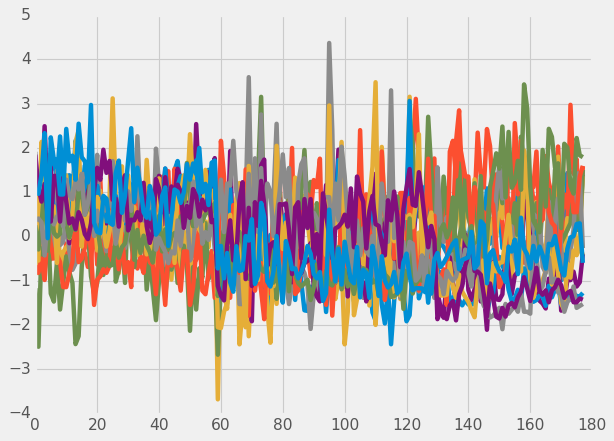

In [454]:
plt.plot(wine.data)

In [0]:
x = torch.from_numpy(wine.data).float()       ## features
y = torch.from_numpy(wine.target).long()      ## target

In [0]:
model = nn.Sequential(
  nn.Linear(13,24),
  nn.ReLU(),
  nn.Linear(24,12),
  nn.ReLU(),
  nn.Linear(12,3),
  nn.Softmax(1)
)

In [0]:
## reset the nn weight to start clean, and retrain
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [0]:
def score(model, x, y):
  model.eval()
  out=model(x)
  _, pred = torch.max(out, 1)

  print "Misclassified %s/%s" % ((y.size(0) - (pred.data==y.data).sum(0)), y.size(0))


In [0]:
EPOCH = 500
lr = .1
lf = nn.CrossEntropyLoss()

In [0]:
# train L-BFGS
def fit_lbfgs(model, optim, Floss, epoch):
  losses = []
  for _ in range(epoch):
    def closure():
      optim.zero_grad()
      yhat = model(x)
      loss = Floss(yhat, y)
      losses.append(loss.item())
      loss.backward()
      return loss
    optim.step(closure)
  return losses


# train Adam, SGD, RMSprop
def fit(model, optim, Floss, epoch):
  losses = []
  for _ in range(epoch):
    optim.zero_grad()
    yhat = model(x)
    loss = Floss(yhat, y)
    losses.append(loss.item())
    loss.backward()
    optim.step()
  return losses


## might need this code at somepoint to plug in
## for validation
## with torch.no_grad():
##  pred = model(x))
##  l = lf(pred, y)

In [445]:

optim_lbfgs   = torch.optim.LBFGS(model.parameters(), lr=lr)
optim_adam    = torch.optim.Adam(model.parameters(), lr=lr)
optim_sgd     = torch.optim.SGD(model.parameters(), lr=lr)
optim_rmsprop = torch.optim.RMSprop(model.parameters(), lr=lr)


model.apply(weight_reset)
model.train()
loss_lbfgs = fit_lbfgs(model, optim_lbfgs, lf, EPOCH)
score(model, x, y)

        
model.apply(weight_reset)
model.train()
loss_adam = fit(model, optim_adam, lf, EPOCH)
score(model, x, y)

model.apply(weight_reset)
model.train()
loss_sgd = fit(model, optim_sgd, lf, EPOCH)
score(model, x, y)

model.apply(weight_reset)
model.train()
loss_rmsprop = fit(model, optim_rmsprop, lf, EPOCH)
score(model, x, y)

Misclassified tensor(0)/178
Misclassified tensor(0)/178
Misclassified tensor(0)/178
Misclassified tensor(107)/178


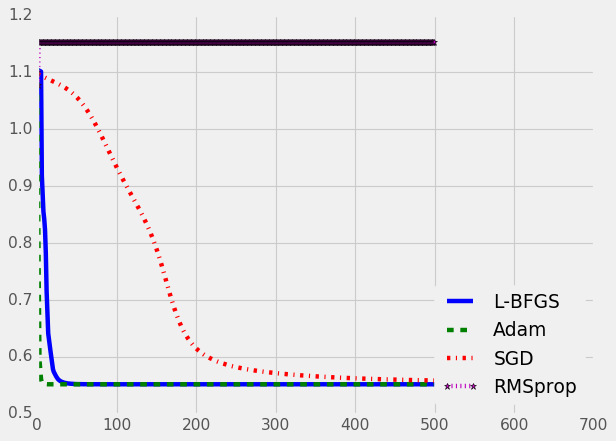

In [452]:
plt.plot(loss_lbfgs, 'b-', label="L-BFGS")
plt.plot(loss_adam, 'g--', label="Adam")
plt.plot(loss_sgd, 'r-.', label="SGD")
plt.plot(loss_rmsprop, 'm:*', label="RMSprop")
plt.legend(loc="lower right")
plt.style.use('fivethirtyeight')

In [447]:
print optim_lbfgs.state_dict
print optim_adam.state_dict
print optim_sgd.state_dict
print optim_rmsprop.state_dict

<bound method LBFGS.state_dict of LBFGS (
Parameter Group 0
    history_size: 100
    line_search_fn: None
    lr: 0.1
    max_eval: 25
    max_iter: 20
    tolerance_change: 1e-09
    tolerance_grad: 1e-05
)>
<bound method Adam.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)>
<bound method SGD.state_dict of SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)>
<bound method RMSprop.state_dict of RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.1
    momentum: 0
    weight_decay: 0
)>
